# Processing chain: Quasi-Vertical Profiles

Daniel Sanchez-Rivas<sup>1</sup>

<sup>1</sup>Department of Meteorology, University of Bonn, Bonn, Germany

This notebook outlines the process of generating QVPs using raw data from either X- or C-band radars.

If you think this repository is helpful, it would be awesome if you could cite the [Towerpy paper](https://www.sciencedirect.com/science/article/pii/S1364815223001329):

> @article{sanchezrivas2023, title = {{Towerpy: An open-source toolbox for processing polarimetric weather radar data}}, journal = {Environmental Modelling & Software}, pages= {105746}, year = {2023}, issn = {1364-8152}, doi = {https://doi.org/10.1016/j.envsoft.2023.105746 }, author = {Daniel Sanchez-Rivas and Miguel Angel Rico-Ramirez}, keywords = {Weather radar, Polarimetry, Radar QPE, Radar research applications, Open source}}

I have the Python script (*.py) version of this notebook available in this same directory *[/radar/qvps/radchain_profs_build.py].*

For a more detailed description of the processing chain, definition of parameters and variables, see the following notebooks:
- [`Processing chain: DWD radar data (Precipitation scans)`](http://localhost:8888/lab/tree/radproc/radchain_dwd.ipynb) in [/radar/radproc/radchain_dwd]
- [`Processing chain: QPE using XPol and DWD radar data)`](http://localhost:8888/lab/tree/radproc/radchain_dwd.ipynb) in [/radar/qpe/rcomp_xpoldwd_qpe]

**This notebook follows the same steps described in those two notebooks, with a few key differences:**
- Here, I use a for loop to process and quality control the data to generate the QVPs.
- There is an argument called `FULL_QC` that determines the level of quality control applied. See below for more details.

## Read-in and quality control

### Import relevant packages

In [1]:
import datetime as dt
from tqdm import tqdm
import os
import pickle
import sys
import numpy as np
import towerpy as tp
import wradlib as wrl
from wradlib.dp import phidp_kdp_vulpiani as kdpvpi
LWDIR = '/home/dsanchez/sciebo_dsr/'
sys.path.append(LWDIR + 'codes/github/unibonnpd/')
from radar.rparams_dwdxpol import RPARAMS
from radar import twpext as tpx

/home/dsanchez/mambaforge/envs/towerpy/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)



You are using the Towerpy framework, an open source library for
working with polarimetric weather radar data.

If you find our work useful for your research, please consider citing our
following publication:

https://doi.org/10.1016/j.envsoft.105746.2023



### Define working directories, date, time, radar sites and scan elevation to be used in the QVPs generation

In [2]:
print(f"X-band radar sites: {[rs['site_name'] for rs in RPARAMS if rs['rband'] == 'X']}")
print(f"C-band radar sites: {[rs['site_name'] for rs in RPARAMS if rs['rband'] == 'C']}")

X-band radar sites: ['Boxpol', 'Juxpol', 'Aaxpol']
C-band radar sites: ['ASR Borkum', 'Boostedt', 'Dresden', 'Eisberg', 'Essen', 'Feldberg', 'Flechtdorf', 'Hannover', 'Isen', 'Memmingen', 'Neuhaus', 'Neuheilenbach', 'Offenthal', 'Protzel', 'Rostock', 'Turkheim', 'Ummendorf']


In [3]:
START_TIME = dt.datetime(2021, 7, 14, 0, 0)

STOP_TIME = START_TIME+dt.timedelta(hours=24)

PTYPE = 'qvps'

EWDIR = '/run/media/dsanchez/PSDD1TB/safe/bonn_postdoc/'
PDIR = None

# Choose one radar site
RSITE = 'Essen'
RPARAMS = {RSITE: next(item for item in RPARAMS if item['site_name'] == RSITE)}
for k1, v1 in RPARAMS.items():
    if k1.lower() == 'boxpol':
        v1['elev'] = 'n_ppi_110deg'
    elif k1.lower() == 'juxpol':
        v1['elev'] = 'sweep_3'
    else:
        v1['elev'] = 'ppi_vol_12.0'

# =============================================================================
# Set plotting parameters
# =============================================================================
PLOT_METHODS = False

### List radar files

In [4]:
RSITE_FILES = {k: tpx.get_listfilesxpol(i['site_name'], START_TIME, STOP_TIME,
                                        i['elev'], parent_dir=PDIR)
               if 'xpol' in i['site_name'].lower() else
               tpx.get_listfilesdwd(i['site_name'], START_TIME, STOP_TIME,
                                    i['elev'], parent_dir=PDIR)
               for k, i in RPARAMS.items()}

### Set directory to save results

In [5]:
if 'xpol' in RSITE:
    RES_DIR = (EWDIR + f'pd_rdres/{PTYPE}/xpol/')
else:
    RES_DIR = (EWDIR + f'pd_rdres/{PTYPE}/dwd/')

### Radar reflectivity $(Z_H)$ offset definition

In [6]:
if 'xpol' in RPARAMS[RSITE]['site_name']:
    # zh_off = RPARAMS[RSITE]['zh_offset'].get(START_TIME.strftime("%Y%m%d"))
    zh_off = 0
else:
    zh_off = 0

### Differential phase $(\Phi_{DP})$ offset defintion

In [7]:
if RPARAMS[RSITE]['site_name'] == 'Juxpol' and START_TIME.year > 2018:
    RPARAMS[RSITE]['signpdp'] = -1
else:
    RPARAMS[RSITE]['signpdp'] = 1

preset_phidp = RPARAMS[RSITE]['phidp_prst'].get(START_TIME.strftime("%Y%m%d"))

###  Noise-level preset values definition

In [8]:
if RPARAMS[RSITE]['site_name'] == 'Boxpol':
    RPARAMS[RSITE]['nlvl'] = (23, 27, .05)
    if START_TIME.year < 2017:
        RPARAMS[RSITE]['nlvl'] = (25, 29, .05)  # 2014
elif RPARAMS[RSITE]['site_name'] == 'Juxpol':
    RPARAMS[RSITE]['nlvl'] = (28.5, 31, 0.05)
    if START_TIME.year < 2017:
        RPARAMS[RSITE]['nlvl'] = (31, 35, 0.05)
elif 'xpol' not in RPARAMS[RSITE]['site_name'] and START_TIME.year >= 2021:
    RPARAMS[RSITE]['nlvl'] = (32, 35, 0.01)  # 12 deg
    RPARAMS[RSITE]['rhvtc'] = (0.95, 1.)  # 12 deg
elif 'xpol' not in RPARAMS[RSITE]['site_name'] and START_TIME.year < 2021:
    RPARAMS[RSITE]['nlvl'] = (28, 33, 0.01)  # 12 deg
    RPARAMS[RSITE]['rhvtc'] = (0.95, 1.)  # 12 deg

###  Quality-control

This parameter determines the level of quality control applied to the data.
1. When set to `False`, the radar data is only corrected for noise biases, and $\Phi_{DP}(0)$ is estimated and adjusted. **I consider this option provides sufficient quality control for identifying the height of the melting layer, correcting the $Z_{DR}$ offset, and classifying the QVPs according to rain intensity.**
2. When set to `True`, the data is corrected for additional error sources, such as (differential) attenuation and radar calibration. $\Phi_{DP}$ undergoes a comprehensive processing sequence that includes smoothing, filtering, and interpolating the signal phase. This process enables the computation of the specific differential phase $(K_{DP})$. **However, this option requires a prior definition of certain parameters, such as the melting layer height, among others.**

To generate fully quality-controlled QVPs, I follow a two-step process. In the first iteration, I generate QVPs with the *'basic'* QC, estimate the necessary parameters and store all the info in separate files. In the second iteration, I use those parameters to complete the corrections.

In [9]:
FULL_QC = False

In [10]:
if FULL_QC:
    if 'xpol' in RSITE:
        RES_DIR = (EWDIR + f'pd_rdres/{PTYPE}/xpol/fqc/')
    else:
        RES_DIR = (EWDIR + f'pd_rdres/{PTYPE}/dwd/fqc/')
    # =============================================================================
    # Read-in QVPs data
    # =============================================================================
    DIRPROFSCAL = (LWDIR + "pd_rdres/qvps_d4calib/"
                   + f"{START_TIME.strftime('%Y%m%d')}/")
    MFS_DIR = (LWDIR + 'codes/github/unibonnpd/radar/nme/xpol_mfs/')
    CLM_DIR = (LWDIR + 'codes/github/unibonnpd/radar/nme/xpol_clm/')
    RCAL_FILES = {RSITE: DIRPROFSCAL+n for n in sorted(os.listdir(DIRPROFSCAL))
                  if PTYPE in n and RPARAMS[RSITE]['site_name'] in n}
    with open(RCAL_FILES[RSITE], 'rb') as breader:
        profs_data = pickle.load(breader)
    mlyrhv = [i for i in profs_data['mlyr'] if ~np.isnan(i.ml_top)]
    mlt_avg = np.nanmean([i.ml_top for i in profs_data['mlyr']])
    mlk_avg = np.nanmean([i.ml_thickness for i in profs_data['mlyr']])
    mlb_avg = np.nanmean([i.ml_bottom for i in profs_data['mlyr']])
    phidpOv = [i for i in profs_data['phidpO'] if ~np.isnan(i.phidp_offset)]
    zdrOv = [i for i in profs_data['zdrO'] if ~np.isnan(i.zdr_offset)]
    # Set parameters related to QC
    if mlb_avg > 1.5:
        temp = 5
        temp = 15
    else:
        temp = 15
    max_diffdtmin = 120
    if (RPARAMS[RSITE]['site_name'] == 'Boxpol'
            and RPARAMS[RSITE]['elev'] != 'n_ppi_010deg'):
        RPARAMS[RSITE]['bclass'] -= 64

### Build QVPs (loop)

In [11]:
rprofs_all = []

for rscan in tqdm(RSITE_FILES[RSITE], desc=f'Building QVPs from {RSITE}'
                  + f" [{START_TIME.strftime('%Y%m%d')}]"):
    rdata = tpx.Rad_scan(rscan, RPARAMS[RSITE]['site_name'])
    try:
        # =====================================================================
        # %%% Import data into towerpy using wradlib
        # =====================================================================
        if rdata.site_name.lower() == 'boxpol':
            rdata.ppi_xpol()
        elif rdata.site_name.lower() == 'juxpol':
            rdata.ppi_xpol(scan_elev=RPARAMS[RSITE]['elev'])
        else:
            rdata.ppi_dwd()
        if PLOT_METHODS:
            tp.datavis.rad_display.plot_setppi(rdata.georef, rdata.params,
                                               rdata.vars)
        rband = RPARAMS[RSITE]['rband']
        # =============================================================================
        # %%% Radar reflectivity $(Z_H)$ offset correction
        # =============================================================================
        rdata.vars['ZH [dBZ]'] += zh_off
        rdata.zh_offset = zh_off
        # =============================================================================
        # %%% Correlation coefficient $(\rho_{HV})$ noise-correction
        # =============================================================================
        rcrho = tpx.rhoHV_Noise_Bias(rdata)
        rcrho.iterate_radcst(
            rdata.georef, rdata.params, rdata.vars, data2correct=rdata.vars,
            noise_lvl=RPARAMS[RSITE]['nlvl'],
            rhohv_theo=RPARAMS[RSITE]['rhvtc'])
        # =============================================================================
        # %%% Noise suppression
        # =============================================================================
        if rdata.params['radar constant [dB]'] <= 0:
            min_snr = -rcrho.rhohv_corrs['Noise level [dB]']
        else:
            min_snr = rcrho.rhohv_corrs['Noise level [dB]']
        # print(f"minSNR = {min_snr:.2f} dB")
        rsnr = tp.eclass.snr.SNR_Classif(rdata)
        rsnr.signalnoiseratio(
            rdata.georef, rdata.params, rcrho.vars,
            min_snr=min_snr,
            data2correct=rcrho.vars, plot_method=PLOT_METHODS)
        # =============================================================================
        # %%% Differential phase $(\Phi_{DP})$ quality control and processing
        # =============================================================================
        ropdp = tp.calib.calib_phidp.PhiDP_Calibration(rdata)
        # Modify the PhiDP sign (only for JXP)
        rsnr.vars['PhiDP [deg]'] *= RPARAMS[RSITE]['signpdp']
        # $\Phi_{DP}(0)$ detection and correction
        ropdp.offsetdetection_ppi(rsnr.vars, preset=preset_phidp)
        ropdp.offset_correction(rsnr.vars['PhiDP [deg]'],
                                phidp_offset=ropdp.phidp_offset,
                                data2correct=rsnr.vars)
        if FULL_QC:
            # =============================================================================
            # %%% Allocate closest dataset from QVPs (for ML, offsets, etc)
            # =============================================================================
            if mlyrhv:
                idx_mlh, mlh_dt = min(zip(range(
                    len([i.scandatetime for i in mlyrhv])),
                        [i.scandatetime for i in mlyrhv]),
                    key=lambda x: (x[1] > rdata.scandatetime,
                                   abs(x[1] - rdata.scandatetime)))
            else:
                idx_mlh, mlh_dt = (0, profs_data['mlyr'][0].scandatetime)
            idx_phidp0, phidp0_dt = min(zip(range(
                len([i.scandatetime for i in phidpOv])),
                    [i.scandatetime for i in phidpOv]),
                key=lambda x: (x[1] > rdata.scandatetime,
                               abs(x[1] - rdata.scandatetime)))
            idx_zdr0, zdr0_dt = min(zip(range(
                len([i.scandatetime for i in zdrOv])),
                    [i.scandatetime for i in zdrOv]),
                key=lambda x: (x[1] > rdata.scandatetime,
                               abs(x[1] - rdata.scandatetime)))
            idx_pclass, pclass_dt = min(zip(range(
                len(profs_data['dtrs'])), profs_data['dtrs']),
                key=lambda x: (x[1] > rdata.scandatetime,
                               abs(x[1] - rdata.scandatetime)))
            # =============================================================================
            # %%% $\Phi_{DP}$ unfolding
            # =============================================================================
            ropdp.phidp_offset_qvps = phidpOv[idx_phidp0].phidp_offset
            uphidp = np.ascontiguousarray(
                wrl.dp.unfold_phi(ropdp.vars['PhiDP [deg]'],
                                  ropdp.vars['rhoHV [-]'],
                                  width=RPARAMS[RSITE]['wu_pdp'],
                                  copy=True).astype(np.float64))
            ropdp.vars['PhiDP [deg]'] = uphidp
            if PLOT_METHODS:
                tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params,
                                                rsnr.vars,
                                                var2plot='PhiDP [deg]')
                tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params,
                                                ropdp.vars,
                                                var2plot='PhiDP [deg]')
            # =============================================================================
            # %%% Non-meteorological echoes identification and removal
            # =============================================================================
            if rdata.site_name.lower() == 'boxpol':
                pathmfscl = MFS_DIR
                clfmap = None
            elif rdata.site_name.lower() == 'juxpol':
                pathmfscl = None
                clfmap = None
            else:
                pathmfscl = None
                rdata2 = tpx.Rad_scan(rscan, RPARAMS[RSITE]['site_name'])
                rdata2.ppi_dwd(get_rvar='cmap')
                clfmap = 1 - tp.utils.radutilities.normalisenanvalues(
                    rdata2.vars['cmap [class]'],
                    np.nanmin(rdata2.vars['cmap [class]']),
                    np.nanmax(rdata2.vars['cmap [class]']))
                clfmap = np.nan_to_num(clfmap, nan=1e-5)

            rnme = tp.eclass.nme.NME_ID(rdata)
            # %%%% Despeckle and removal of linear signatures
            rnme.lsinterference_filter(rdata.georef, rdata.params, ropdp.vars,
                                       rhv_min=RPARAMS[RSITE]['rhvmin'],
                                       data2correct=ropdp.vars,
                                       plot_method=PLOT_METHODS)
            rnme.clutter_id(rdata.georef, rdata.params, rnme.vars,
                            path_mfs=pathmfscl, min_snr=rsnr.min_snr,
                            binary_class=0,
                            clmap=clfmap, data2correct=rnme.vars,
                            plot_method=PLOT_METHODS)
            if PLOT_METHODS:
                tp.datavis.rad_display.plot_setppi(rdata.georef, rdata.params,
                                                   rnme.vars)
            # ============================================================================
            # %%% Melting layer allocation
            # ============================================================================
            rmlyr = tp.ml.mlyr.MeltingLayer(rdata)
            if ((abs((mlh_dt - rmlyr.scandatetime).total_seconds())/60)
                    <= max_diffdtmin) and mlyrhv:
                rmlyr.ml_bottom = mlyrhv[idx_mlh].ml_bottom
                rmlyr.ml_top = mlyrhv[idx_mlh].ml_top
                rmlyr.ml_thickness = mlyrhv[idx_mlh].ml_thickness
                if (np.isnan(rmlyr.ml_thickness) and ~np.isnan(rmlyr.ml_bottom)):
                    rmlyr.ml_thickness = rmlyr.ml_top - rmlyr.ml_bottom
                # print(f'{rmlyr.site_name} ML_h in database')
            elif (~np.isnan(mlt_avg) and ~np.isnan(mlk_avg)):
                rmlyr.ml_top = mlt_avg
                rmlyr.ml_thickness = mlk_avg
                rmlyr.ml_bottom = rmlyr.ml_top - rmlyr.ml_thickness
                # print(f'{rmlyr.site_name} ML_h in database lies too far,'
                #       + ' using the day-average value')
            elif (np.isnan(mlt_avg) and np.isnan(mlk_avg)):
                # print(f'{rmlyr.site_name} ML_h not in database,'
                #       + ' using the preset value')
                rmlyr.ml_top = RPARAMS[RSITE]['mlt']
                rmlyr.ml_thickness = RPARAMS[RSITE]['mlk']
                rmlyr.ml_bottom = rmlyr.ml_top-rmlyr.ml_thickness
            # PPI MLYR
            rmlyr.ml_ppidelimitation(rdata.georef, rdata.params, rsnr.vars)
            if PLOT_METHODS:
                tp.datavis.rad_display.plot_setppi(rdata.georef, rdata.params,
                                                   rnme.vars, mlyr=rmlyr)
            # =====================================================================
            # %%% Differential reflectivity $(Z_{DR})$ offset correction
            # =============================================================================
            rozdr = tp.calib.calib_zdr.ZDR_Calibration(rdata)
            if ((abs((zdr0_dt - rozdr.scandatetime).total_seconds())/60)
                    <= max_diffdtmin):
                rozdr.zdr_offset = zdrOv[idx_zdr0].zdr_offset
                if rozdr.zdr_offset == 0 or np.isnan(rozdr.zdr_offset):
                    rozdr.zdr_offset = RPARAMS[RSITE]['zdr_offset']
            else:
                rozdr.zdr_offset = RPARAMS[RSITE]['zdr_offset']
            rozdr.offset_correction(rnme.vars['ZDR [dB]'],
                                    zdr_offset=rozdr.zdr_offset,
                                    data2correct=rnme.vars)
            if PLOT_METHODS:
                tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params,
                                                rnme.vars, var2plot='ZDR [dB]')
                tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params,
                                                rozdr.vars,
                                                var2plot='ZDR [dB]')
            # =============================================================================
            # %%% Radar reflectivity $(Z_H)$ attenuation correction
            # =============================================================================
            rattc = tp.attc.attc_zhzdr.AttenuationCorrection(rdata)
            if ((abs((pclass_dt - rattc.scandatetime).total_seconds())/60)
                    <= max_diffdtmin):
                pcp_its = profs_data['pcp_type'][idx_pclass]
            else:
                pcp_its = 1
            if rband == 'C' and (pcp_its == 0 or pcp_its == 1 or pcp_its == 4):
                att_alpha = [0.05, 0.1, 0.08]  # Light to moderate rain
                rb_a = 0.39  # Continental
                # print(f'scan LR-{rband}-{att_alpha}')
            elif rband == 'C' and (pcp_its == 2 or pcp_its == 5):
                att_alpha = [0.1, 0.18, 0.08]  # Moderate to heavy rain
                # rb_a = 0.39  # Continental
                rb_a = 0.27  # Continental
                # print(f'scan MR-{rband}-{att_alpha}')
            elif rband == 'C' and (pcp_its == 3 or pcp_its == 6):
                att_alpha = [0.1, 0.18, 0.08]  # Moderate to heavy rain
                rb_a = 0.14  # Tropical
                # att_alpha = [0.05, 0.18, 0.11]  # Light - heavy rain
                # print(f'scan HR-{rband}-{att_alpha}')
            if rband == 'X' and (pcp_its == 0 or pcp_its == 1 or pcp_its == 4):
                att_alpha = [0.15, 0.30, 0.28]  # Light rain PARK
                rb_a = 0.19  # Continental
                # print(f'scan LR-{rband}-{att_alpha}')
            elif rband == 'X' and (pcp_its == 2 or pcp_its == 5):
                att_alpha = [0.30, 0.45, 0.28]  # Moderate to heavy rain PARK
                rb_a = 0.17  # Continental
                # print(f'scan MR-{rband}-{att_alpha}')
            elif rband == 'X' and (pcp_its == 3 or pcp_its == 6):
                att_alpha = [0.30, 0.45, 0.28]  # Moderate to heavy rain PARK
                rb_a = 0.14  # Tropical
                # att_alpha = [0.15, 0.35, 0.22]  # Light - heavy rain
                # print(f'scan HR-{rband}-{att_alpha}')
            # %%%% $\Phi_{DP}$  processing for attenuation correction
            rattc.attc_phidp_prepro(
                rdata.georef, rdata.params, rozdr.vars, rhohv_min=0.7,
                phidp0_correction=(True if (rattc.site_name == 'Offenthal')
                                   or (rattc.site_name == 'Flechtdorf')
                                   or (rattc.site_name == 'Neuheilenbach')
                                   else False))
            if PLOT_METHODS:
                tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params,
                                                rozdr.vars,
                                                var2plot='PhiDP [deg]')
                tp.datavis.rad_display.plot_ppi(rdata.georef, rdata.params,
                                                rattc.vars,
                                                var2plot='PhiDP [deg]')
            # %%%% $Z_{H}$ attenuation correction
            if ('xpol' in rattc.site_name.lower()
               or rattc.site_name.lower() == 'aachen'):
                rattc.zh_correction(
                    rdata.georef, rdata.params, rattc.vars,
                    rnme.nme_classif['classif [EC]'], mlyr=rmlyr,
                    # rnme.ls_dsp_class['classif [EC]'], mlyr=rmlyr,
                    attc_method='ABRI', pdp_dmin=1, pdp_pxavr_azm=3,
                    pdp_pxavr_rng=round(4000/rdata.params['gateres [m]']),
                    phidp0=0, coeff_alpha=att_alpha,
                    # coeff_a=[9.781e-5, 1.749e-4, 1.367e-4],  # Park
                    # coeff_b=[0.757, 0.804, 0.78],  # Park
                    coeff_a=[5.50e-5, 1.62e-4, 9.745e-05],  # Diederich
                    coeff_b=[0.74, 0.86, 0.8],  # Diederich
                    plot_method=PLOT_METHODS)
            else:
                rattc.zh_correction(
                    rdata.georef, rdata.params, rattc.vars,
                    rnme.nme_classif['classif [EC]'], mlyr=rmlyr,
                    # rnme.ls_dsp_class['classif [EC]'], mlyr=rmlyr,
                    attc_method='ABRI', pdp_dmin=1, pdp_pxavr_azm=3,
                    pdp_pxavr_rng=round(4000/rdata.params['gateres [m]']),
                    phidp0=0, coeff_alpha=att_alpha,
                    # coeff_a=[1.59e-5, 4.27e-5, 2.49e-05],  # Diederich
                    # coeff_b=[0.73, 0.77, 0.755],  # Diederich
                    coeff_a=[1e-5, 4.27e-5, 3e-05],  # MRR+Diederich
                    coeff_b=[0.73, 0.85, 0.78],  # MRR+Diederich
                    plot_method=PLOT_METHODS)
            # =============================================================================
            # %%% Computation of $Z_H(A_H)$ (for PBB, wet radome and miscalibration)
            # =============================================================================
            rzhah = tp.attc.r_att_refl.Attn_Refl_Relation(rdata)
            rzhah.ah_zh(rattc.vars, zh_upper_lim=55, temp=temp, rband=rband,
                        copy_ofr=True, data2correct=rattc.vars)
            rattc.vars['ZH* [dBZ]'] = rzhah.vars['ZH [dBZ]']
            mov_avrgf_len = (1, 5)
            zh_difnan = np.where(rzhah.vars['diff [dBZ]'] == 0, np.nan,
                                 rzhah.vars['diff [dBZ]'])
            zhpdiff = np.array([np.nanmedian(i) if ~np.isnan(np.nanmedian(i))
                                else 0 for cnt, i in enumerate(zh_difnan)])
            zhpdiff_pad = np.pad(zhpdiff, mov_avrgf_len[1]//2, mode='wrap')
            zhplus_maf = np.ma.convolve(
                zhpdiff_pad, np.ones(mov_avrgf_len[1])/mov_avrgf_len[1],
                mode='valid')
            rattc.vars['ZH+ [dBZ]'] = np.array(
                [rattc.vars['ZH [dBZ]'][cnt] - i if i == 0
                 else rattc.vars['ZH [dBZ]'][cnt] - zhplus_maf[cnt]
                 for cnt, i in enumerate(zhpdiff)])
            if PLOT_METHODS:
                tp.datavis.rad_display.plot_ppidiff(
                    rdata.georef, rdata.params, rattc.vars, rattc.vars,
                    var2plot1='ZH [dBZ]', var2plot2='ZH+ [dBZ]')
            # =============================================================================
            # %%% $Z_{DR}$ attenuation correction
            # =============================================================================
            zhzdr_a = 0.000249173
            zhzdr_b = 2.33327
            if rband == 'C':
                zdr_attc = (9, 5, 3)
            else:
                zdr_attc = (7, 10, 5)
            rattc.zdr_correction(rdata.georef, rdata.params, rozdr.vars,
                                 rzhah.vars, rnme.nme_classif['classif [EC]'],
                                 # rzhah.vars, rnme.ls_dsp_class['classif [EC]'],
                                 mlyr=rmlyr, attc_method='BRI',
                                 coeff_beta=RPARAMS[RSITE]['beta'],
                                 beta_alpha_ratio=rb_a,
                                 rhv_thld=RPARAMS[RSITE]['rhvatt'],
                                 mov_avrgf_len=zdr_attc[0],
                                 minbins=zdr_attc[1], p2avrf=zdr_attc[2],
                                 zh_zdr_model='exp',
                                 rparams={'coeff_a': zhzdr_a,
                                          'coeff_b': zhzdr_b},
                                 plot_method=PLOT_METHODS)
            # =============================================================================
            # %%% Specific differential phase $(K_{DP})$ calculation
            # =============================================================================
            # KDP Vulpiani
            if rband == 'C':
                zh_kdp = 'ZH+ [dBZ]'
            elif rband == 'X':
                zh_kdp = 'ZH+ [dBZ]'
            rkdpv = {}
            kdp_vulp = kdpvpi(
                rattc.vars['PhiDP [deg]'], dr=rdata.params['gateres [m]']/1000,
                winlen=RPARAMS[RSITE]['kdpwl'], copy=True)
            rkdpv['PhiDP [deg]'] = kdp_vulp[0]
            rkdpv['KDP [deg/km]'] = kdp_vulp[1]
            # Remove NME
            rattc.vars['KDP* [deg/km]'] = np.where(
                rnme.nme_classif['classif [EC]'] != 0, np.nan,
                # rnme.ls_dsp_class['classif [EC]'] != 0, np.nan,
                rkdpv['KDP [deg/km]'])
            # Remove negative KDP values in rain region and within ZH threshold
            rattc.vars['KDP* [deg/km]'] = np.where(
                (rmlyr.mlyr_limits['pcp_region [HC]'] == 1)
                & (rkdpv['KDP [deg/km]'] < 0) & (rattc.vars[zh_kdp] > 5),
                0, rattc.vars['KDP* [deg/km]'])
            # Patch KDP* using KDP+ using thresholds in ZH and rhoHV
            rattc.vars['KDP+ [deg/km]'] = np.where(
                (rattc.vars[zh_kdp] >= 40) & (rattc.vars[zh_kdp] < 55)
                & (rozdr.vars['rhoHV [-]'] >= 0.95)
                & (~np.isnan(rattc.vars['KDP [deg/km]']))
                & (rattc.vars['KDP [deg/km]'] != 0),
                rattc.vars['KDP [deg/km]'], rattc.vars['KDP* [deg/km]'])
            if PLOT_METHODS:
                tp.datavis.rad_display.plot_ppidiff(
                    rdata.georef, rdata.params, rattc.vars, rattc.vars,
                    var2plot1='KDP* [deg/km]', var2plot2='KDP+ [deg/km]',
                    diff_lims=[-1, 1, 0.1],
                    vars_bounds={'KDP [deg/km]': (-1, 3, 17)})
        # =============================================================================
        # %%% Create a new Towerpy object to store processed data
        # =============================================================================
        # rd_qc4ps = tp.attc.attc_zhzdr.AttenuationCorrection(rdata)
        rd_qc4ps = tp.calib.calib_phidp.PhiDP_Calibration(rdata)
        rd_qc4ps.georef = rdata.georef
        rd_qc4ps.params = rdata.params
        rd_qc4ps.min_snr = rsnr.min_snr
        rd_qc4ps.zh_offset = zh_off
        rd_qc4ps.phidp0 = ropdp.phidp_offset
        # rd_qc4ps.vars = dict(rattc.vars)
        rd_qc4ps.vars = {}
        rd_qc4ps.vars['ZH [dBZ]'] = ropdp.vars['ZH [dBZ]']
        rd_qc4ps.vars['ZDR [dB]'] = ropdp.vars['ZDR [dB]']
        rd_qc4ps.vars['PhiDP [deg]'] = ropdp.vars['PhiDP [deg]']
        rd_qc4ps.vars['rhoHV [-]'] = ropdp.vars['rhoHV [-]']
        if FULL_QC:
            rd_qc4ps.beta_alpha_ratio = rb_a
            rd_qc4ps.phidp0_qvps = ropdp.phidp_offset_qvps
            rd_qc4ps.zdr_offset = rozdr.zdr_offset
            rd_qc4ps.ml_top = rmlyr.ml_top
            rd_qc4ps.ml_thickness = rmlyr.ml_thickness
            rd_qc4ps.ml_bottom = rmlyr.ml_bottom
            rd_qc4ps.vars['ZH [dBZ]'] = rozdr.vars['ZH [dBZ]']
            rd_qc4ps.vars['ZDR [dB]'] = rattc.vars['ZDR [dB]']
            rd_qc4ps.vars['PhiDP [deg]'] = rattc.vars['PhiDP [deg]']
            rd_qc4ps.vars['rhoHV [-]'] = rozdr.vars['rhoHV [-]']
            rd_qc4ps.vars['AH [dB/km]'] = rattc.vars['AH [dB/km]']
            rd_qc4ps.vars['KDP [deg/km]'] = rattc.vars['KDP+ [deg/km]']
            rd_qc4ps.vars['ZHa [dBZ]'] = rattc.vars['ZH [dBZ]']
            rd_qc4ps.vars['ZH+ [dBZ]'] = rattc.vars['ZH+ [dBZ]']
        # =============================================================================
        # %%% Create polarimetric profiles object
        # =============================================================================
        rprofs = tp.profs.polprofs.PolarimetricProfiles(rd_qc4ps)
        rprofs.pol_qvps(rdata.georef, rdata.params, rd_qc4ps.vars, stats=True)
        rprofs.zh_offset = zh_off
        rprofs.phidp0 = ropdp.phidp_offset
        if FULL_QC:
            rprofs.phidp0_qvps = ropdp.phidp_offset_qvps
            rprofs.zdr_offset = rozdr.zdr_offset
            rprofs.ml_top = rmlyr.ml_top
            rprofs.ml_thickness = rmlyr.ml_thickness
            rprofs.ml_bottom = rmlyr.ml_bottom
        rprofs_all.append(rprofs)
    except Exception as err:
        log_file = open(RES_DIR+'log.txt', 'a')
        log_file.write(
            f'{dt.datetime.now().strftime("%Y-%m-%d--%H:%M:%S:")}'
            + f'Error in {rdata.file_name}- {err}'+'\n')
        pass

Building QVPs from Essen [20210714]: 100%|████████████████████████████████████████████████████████████████████████████████| 288/288 [14:39<00:00,  3.05s/it]


## Visualisation of the results

### Single profile plot

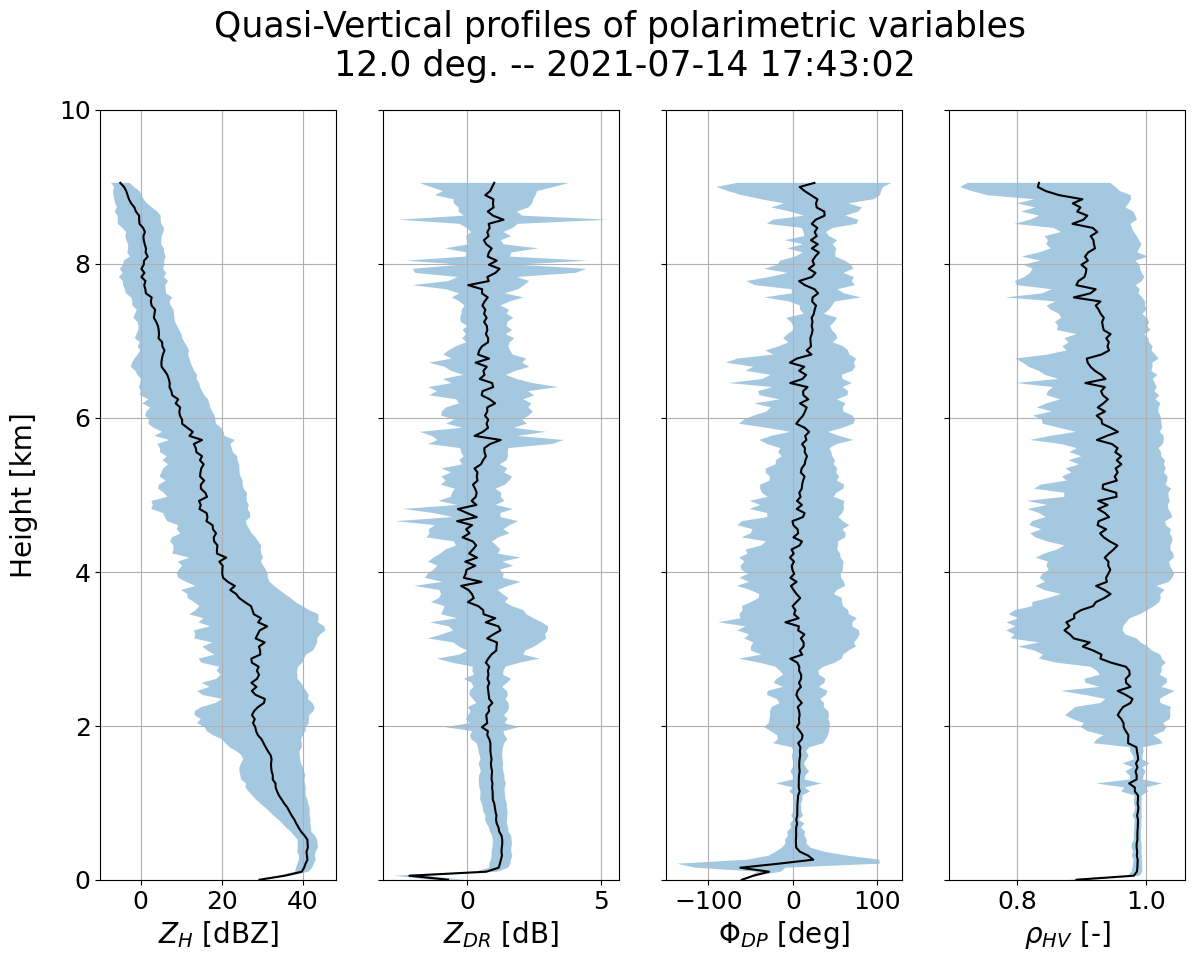

<Figure size 640x480 with 0 Axes>

In [12]:
tp.datavis.rad_display.plot_radprofiles(
    rprofs_all[212], rprofs_all[212].georef['profiles_height [km]'], colours=False,
    stats='std_dev')

### Height-versus-time plot of QVPs

#### The rad_interactive module

Check or uncheck the following line to enable the use of widgets in the notebook. *ipympl* is required.

In [13]:
# %matplotlib ipympl

This module helps explore the QVPs in a Height-versus-time format.

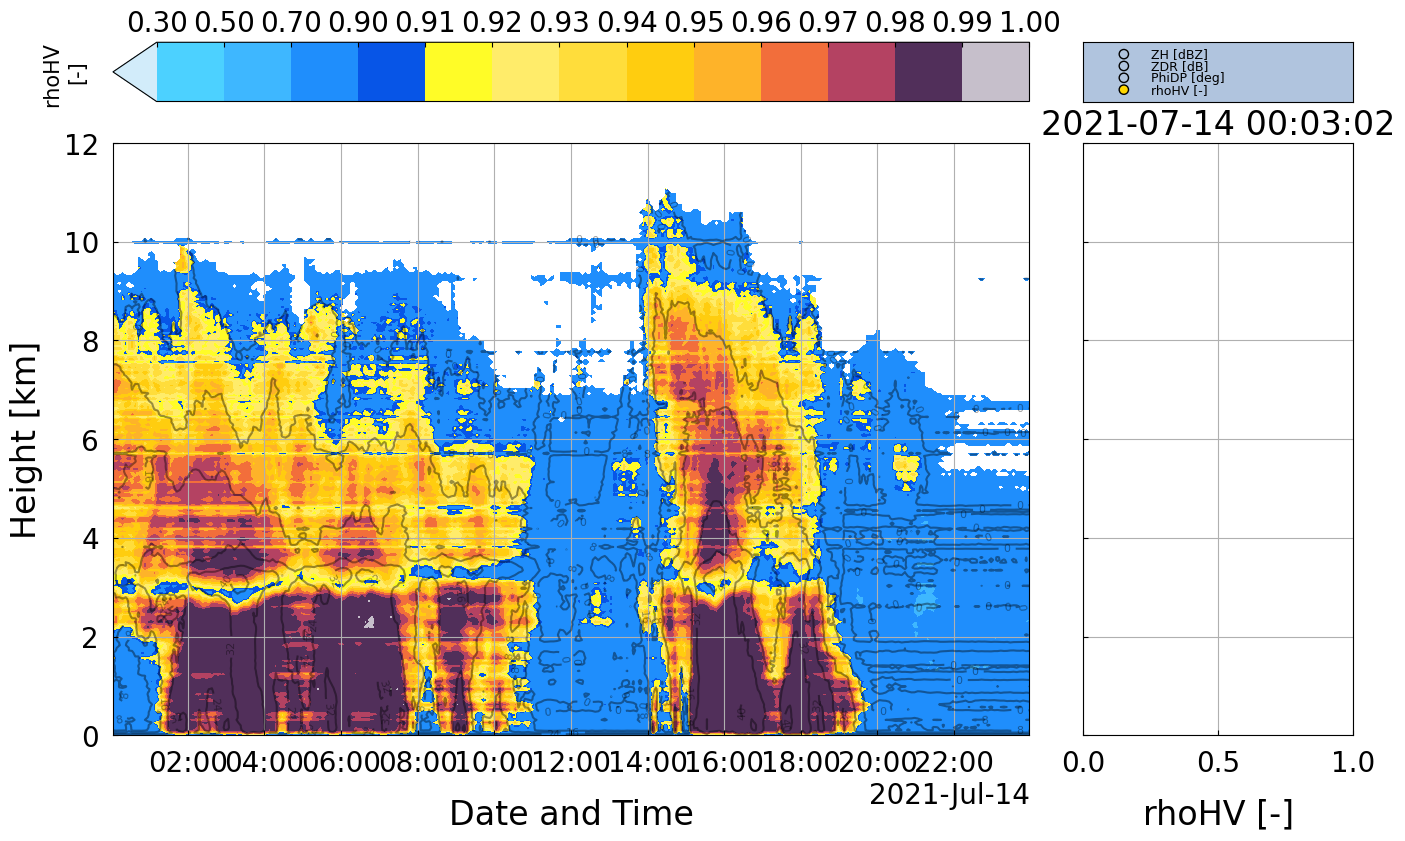

0

In [14]:
radb = tp.datavis.rad_interactive.hti_base(
    rprofs_all, stats='std_dev',
    var2plot='rhoHV [-]',
    htiylim=[0, 12],
    ptype='fcontour',
    contourl='ZH [dBZ]',
    tz='Europe/Berlin')
radexpvis = tp.datavis.rad_interactive.HTI_Int()
radb.on_clicked(radexpvis.hzfunc)

## References

- Bringi, V. N., Keenan, T. D., & Chandrasekar, V. (2001). Correcting C-band radar reflectivity and differential reflectivity data for rain attenuation: A self-consistent method with constraints. IEEE Transactions on Geoscience and Remote Sensing, 39(9), 1906–1915. https://doi.org/10.1109/36.951081
- Chen, J.-Y., Trömel, S., Ryzhkov, A., & Simmer, C. (2021). Assessing the benefits of specific attenuation for quantitative precipitation estimation with a C-band radar network. Journal of Hydrometeorology. https://doi.org/10.1175/JHM-D-20-0299.1
- Diederich, M., Ryzhkov, A., Simmer, C., Zhang, P., & Trömel, S. (2015). Use of Specific Attenuation for Rainfall Measurement at X-Band Radar Wavelengths. Part I: Radar Calibration and Partial Beam Blockage Estimation. Journal of Hydrometeorology, 16(2), 487–502. https://doi.org/10.1175/JHM-D-14-0066.1
- Heistermann, M., Jacobi, S., and Pfaff, T.: Technical Note: An open source library for processing weather radar data (wradlib), Hydrol. Earth Syst. Sci., 17, 863-871, doi:10.5194/hess-17-863-2013, 2013
- Park, S. G., Bringi, V. N., Chandrasekar, V., Maki, M., & Iwanami, K. (2005). Correction of radar reflectivity and differential reflectivity for rain attenuation at X band. Part I: Theoretical and empirical basis. Journal of Atmospheric and Oceanic Technology, 22(11), 1621–1632. https://doi.org/10.1175/JTECH1803.1
- Rico-Ramirez, M. A., & Cluckie, I. D. (2008). Classification of ground clutter and anomalous propagation using dual-polarization weather radar. IEEE Transactions on Geoscience and Remote Sensing, 46(7), 1892–1904. https://doi.org/10.1109/TGRS.2008.916979
- Rico-Ramirez, M. A. (2012). Adaptive attenuation correction techniques for C-band polarimetric weather radars. IEEE Transactions on Geoscience and Remote Sensing, 50(12), 5061–5071. https://doi.org/10.1109/TGRS.2012.2195228
- Ryzhkov, A. V., & Zrnic, D. S. (2019). Radar Polarimetry for Weather Observations. Springer International Publishing. https://doi.org/10.1007/978-3-030-05093-1
- Sanchez-Rivas, D., & Rico-Ramirez, M. A. (2021). Detection of the melting level with polarimetric weather radar. Atmospheric Measurement Techniques, 14(4), 2873–2890. https://doi.org/10.5194/amt-14-2873-2021
- Sanchez-Rivas, D., & Rico-Ramirez, M. A. (2022). Calibration of radar differential reflectivity using quasi-vertical profiles. Atmospheric Measurement Techniques, 15(2), 503–520. https://doi.org/10.5194/amt-15-503-2022
- Sanchez-Rivas, D., & Rico-Ramirez, M. A. (2023). Towerpy: An open-source toolbox for processing polarimetric weather radar data. Environmental Modelling & Software, 167, 105746. https://doi.org/10.1016/j.envsoft.2023.105746
- Trömel, S., Ziegert, M., Ryzhkov, A. V., Chwala, C., & Simmer, C. (2014). Using Microwave Backhaul Links to Optimize the Performance of Algorithms for Rainfall Estimation and Attenuation Correction. Journal of Atmospheric and Oceanic Technology, 31(8), 1748–1760. https://doi.org/10.1175/JTECH-D-14-00016.1
- Vulpiani, G., Montopoli, M., Passeri, L. D., Gioia, A. G., Giordano, P., & Marzano, F. S. (2012). On the Use of Dual-Polarized C-Band Radar for Operational Rainfall Retrieval in Mountainous Areas. Journal of Applied Meteorology and Climatology, 51(2), 405–425. https://doi.org/10.1175/JAMC-D-10-05024.1